# Exploring Quant Indicators

This notebook explores various commonly used technical indicators for financial time-series data. Using historical prices of Singapore Airlines[C6L.SI], we compute and visualize key indicators such as  

- Simple Moving Average (SMA)
- Exponential Moving Average (EMA)
- Relative Strength Index (RSI)
- Bollinger Bands
- Moving Average Convergence Divergence (MACD)
- Momentum

These indicators are useful for understanding trend direction, volatility, and potential buy/sell signals.

### Installing and importing required libraries


In [2]:
!pip install yfinance ta matplotlib pandas
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, ROCIndicator
from ta.volatility import BollingerBands

## Import and Pre-processing Data
We use Yahoo Finance to download daily adjusted close prices for our chosen stock over the time period 2020-01-01 to 2025-06-01. We also check for any null values in the dataset. We also note that the "Close" price column is of the data type pandas.core.frame.DataFrame while we need a Series data type, which will be done next.

In [3]:
ticker = 'C6L.SI'
start_date = '2020-01-01'
end_date = '2025-06-01'

df = yf.download(ticker, start=start_date, end=end_date)
print(df.isnull().sum())
type(df.Close)


/tmp/ipykernel_3903/1090566497.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price   Ticker
Close   C6L.SI    0
High    C6L.SI    0
Low     C6L.SI    0
Open    C6L.SI    0
Volume  C6L.SI    0
dtype: int64


pandas.core.frame.DataFrame

## Extracting the Close Price Series
We extract the "Close" price column from the downloaded DataFrame and convert it into a Pandas series. This allows us to work with just the closing prices, which are often used in technical indicators and price-trend analysis. It converts the column to a 1D NumPy array from its 2D form, and creates a Pandas Series.

In [4]:
close = pd.Series(df['Close'].values.squeeze(), index=df.index)

## Computing and Plotting Technical Indicators
A technical indicator is a mathematical pattern derived from historical data used by technical traders or investors to predict future price trends and make trading decisions. 

### Simple Moving Average
Simple Moving Average(SMA) refers to stock's average closing price over a specified price. It is called as a moving average, as average of a subset of the data points is taken based on fixed window. Since SMA is constructed using past closing prices, it is a lag indicator : it is not predictive of future prices. 



In [5]:
# Moving Averages
df['SMA_20'] = SMAIndicator(close=close, window=20).sma_indicator()
df['SMA_50'] = SMAIndicator(close=close, window=50).sma_indicator()

#### Trading Strategies using SMA
1. SMA Intersections - Perform analysis based on when the stock price-line intersects the SMA line. From the graph below, we observe that when the price moves above the SMA line, it often signals an upward trend that continues for a while. Technical traders commonly interpret this as a potential buying opportunity. Conversely, when the price crosses below the SMA line, a downward trend tends to follow, which may serve as a signal to consider selling. 

2. SMA Crossover Strategy - This strategy involves plotting two Simple Moving Average (SMA) lines using different time frames. The SMA with the longer time frame is called the slow signal, while the one with the shorter time frame is known as the fast signal. A buy signal is generated when the fast SMA crosses above the slow SMA, indicating a potential upward trend in the stock price. A sell signal occurs when the fast SMA crosses below the slow SMA, suggesting that the stock price may decline in the near future. (Example : Whenever SMA20 is above the SMA50 line, we buy)

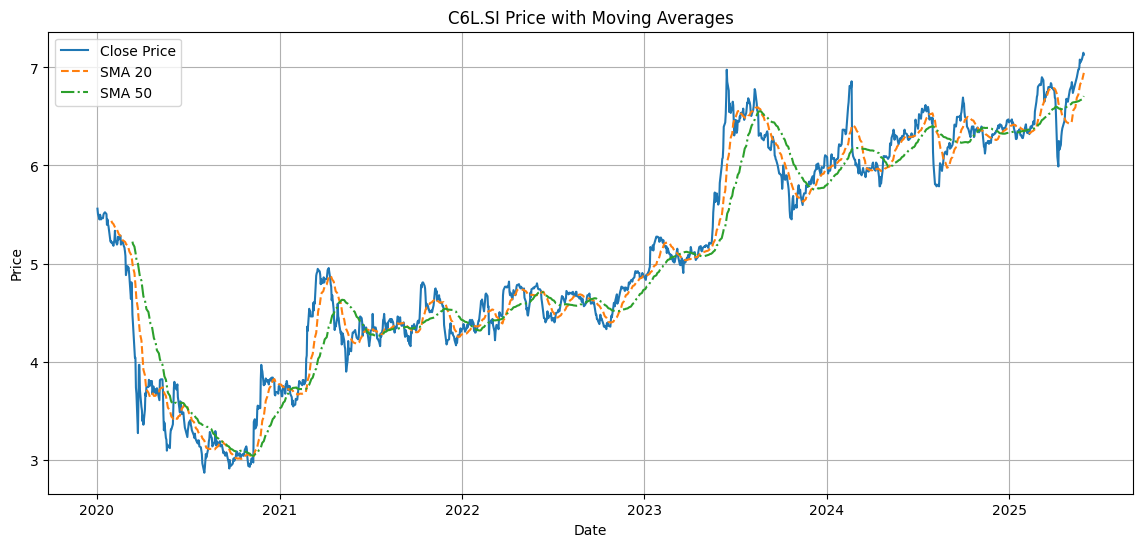

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df['SMA_50'], label='SMA 50', linestyle='-.')
plt.title('C6L.SI Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Exponential Moving Averages
The **Exponential Moving Average (EMA)** differs from the **Simple Moving Average (SMA)** in that it gives more weight to recent data points (i.e., more recent prices), making it more responsive to recent price changes. Like the SMA, the EMA is a **lagging indicator**, but it reacts more quickly to price movements.

The EMA is calculated using the following recursive formula:

$$
\text{EMA}_t = \alpha \cdot \text{Price}_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
$$

Where:
- $\text{EMA}_t$: EMA at time $t$  
- $\text{Price}_t$: Price at time $t$  
- $\alpha = \frac{2}{n + 1}$: Smoothing factor  
- $n$: Number of periods (time window)  
- $\text{EMA}_{t-1}$: EMA at the previous time step
 
 Support and Resistance Bands?


In [7]:
df['EMA_9'] = EMAIndicator(close=close, window=9).ema_indicator()
df['EMA_21'] = EMAIndicator(close=close, window=21).ema_indicator()

### EMA Trading Strategies
1. EMA Crossover Strategy : Use two EMAs with different periods - typically a short-term EMA(fast) and a long term EMA(slow). We choose to buy when the fast EMA crosses above the slow EMA, while we sell when the fast EMA crosses below the slow EMA. This can be a potentially useful strategy as EMA reacts faster than SMA, but may result in more false positives.

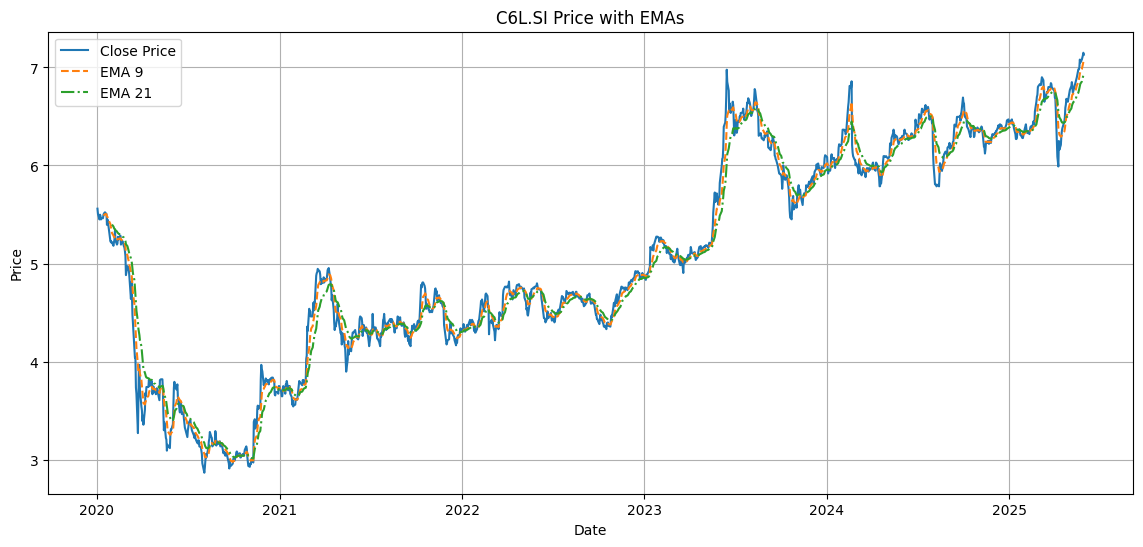

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['EMA_9'], label='EMA 9', linestyle='--')
plt.plot(df['EMA_21'], label='EMA 21', linestyle='-.')
plt.title('C6L.SI Price with EMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

2. EMA + SMA Confirmation Strategy : This strategy involves combining EMA and SMA to reduce false signals by using a EMA for entry/exit timing and SMA to confirm the overall trend. 
- Only act on EMA crossovers(buy) if the price is also above the 50-day SMA(i.e, in an uptrend)
- We can ignore any bullish signals from the EMA if the price is below the 50-day SMA, as the overall trend might still be down
This strategy helps reduce noise and false breakouts.

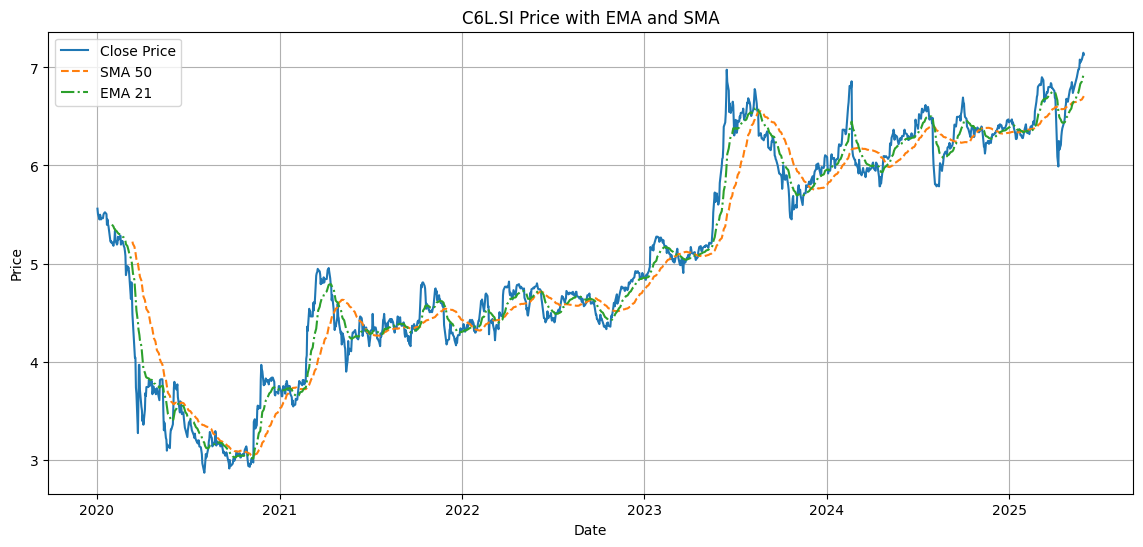

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(df['EMA_21'], label='EMA 21', linestyle='-.')
plt.title('C6L.SI Price with EMA and SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

3. Price Crosses EMA Strategy - Track when the price itself crosses above or below an EMA. We can choose to buy when the price cross above the EMA - potential uptrend or sell when the price crosses below the EMA.

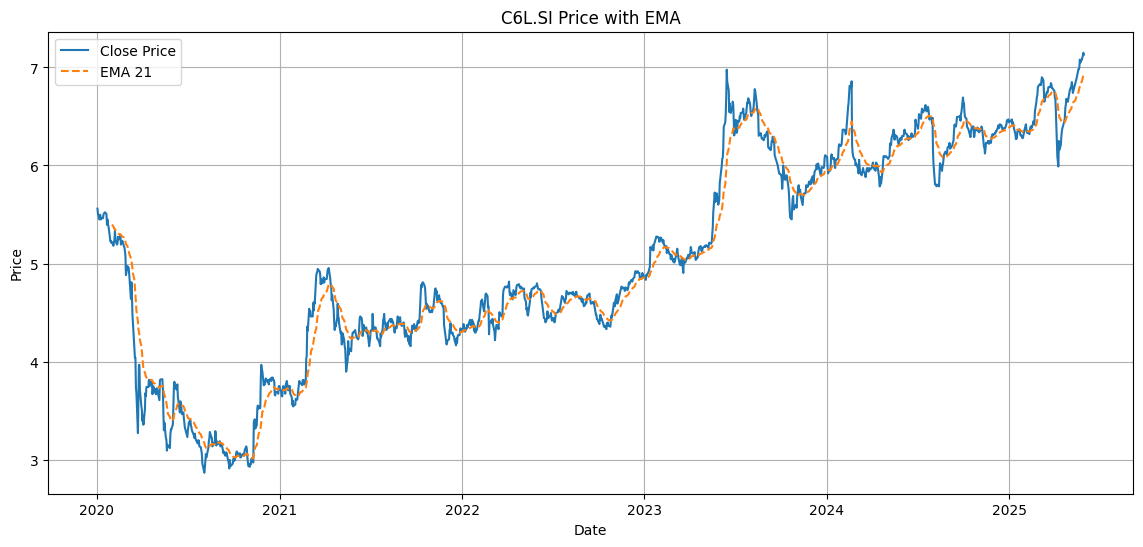

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['EMA_21'], label='EMA 21', linestyle='--')
plt.title('C6L.SI Price with EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

##  Relative Strength Index (RSI)

The **Relative Strength Index (RSI)** is one of the most widely used **momentum oscillators** in technical analysis. It measures both the **speed** and **magnitude** of recent price changes to evaluate overbought or oversold conditions in a stock or asset. RSI values range from **0 to 100**, and are typically calculated using a **14-period** window.

- An RSI value **above 70** is generally considered **overbought**, indicating that the asset may be overvalued and could be due for a price correction or pullback.
- An RSI value **below 30** is considered **oversold**, suggesting that the asset may be undervalued and a price rebound could be expected.

Traders often use RSI to identify **potential reversal points** or to confirm trends when used in combination with other indicators like SMA or EMA.

### RSI Formula

The RSI is calculated using the following formula:

$$
\text{RSI} = 100 - \left( \frac{100}{1 + RS} \right)
$$

Where:

- $RS = \frac{\text{Average Gain over n periods}}{\text{Average Loss over n periods}}$
- Typically, \( n = 14 \) periods (e.g., 14 days for daily data)

This formula ensures the RSI reacts to recent price momentum while staying bounded between 0 and 100.


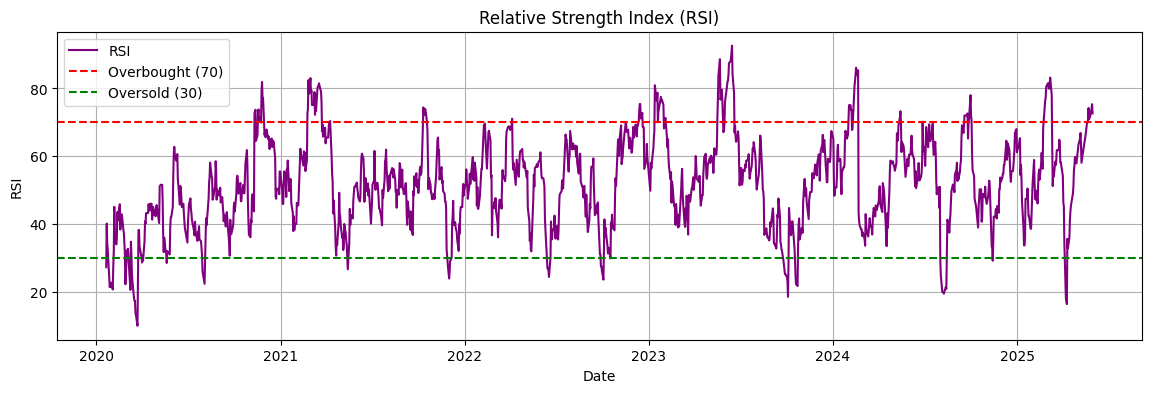

In [11]:
# RSI
df['RSI'] = RSIIndicator(close=close, window=14).rsi()
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# MACD
macd = MACD(close=close)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

# Bollinger Bands
bb = BollingerBands(close=close, window=20, window_dev=2)
df['BB_upper'] = bb.bollinger_hband()
df['BB_lower'] = bb.bollinger_lband()

# Momentum (Rate of Change)
df['Momentum'] = ROCIndicator(close=close, window=10).roc()

In [51]:
print(df[['Close', 'SMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower', 'Momentum']].tail())

Price       Close  SMA_20    EMA_50        RSI      MACD MACD_signal  \
Ticker     C6L.SI                                                      
Date                                                                   
2025-05-26   7.08  6.8555  6.717559  72.241481  0.126735    0.105239   
2025-05-27   7.10  6.8765  6.732556  73.137916  0.129599    0.110111   
2025-05-28   7.12  6.9000  6.747750  74.040734  0.131962    0.114481   
2025-05-29   7.15  6.9235  6.763525  75.377548  0.134703    0.118526   
2025-05-30   7.13  6.9445  6.777896  72.690078  0.133720    0.121564   

Price       BB_upper  BB_lower  Momentum  
Ticker                                    
Date                                      
2025-05-26  7.120941  6.590059  4.733723  
2025-05-27  7.149430  6.603570  3.801166  
2025-05-28  7.171809  6.628191  3.790084  
2025-05-29  7.196430  6.650570  3.924418  
2025-05-30  7.213087  6.675913  3.333334  


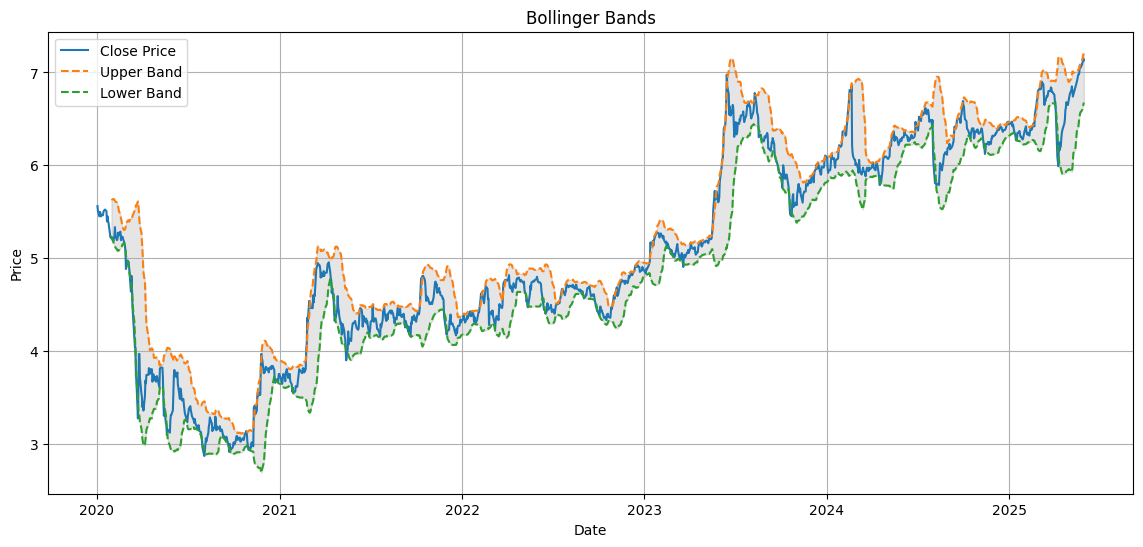

In [53]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['BB_upper'], label='Upper Band', linestyle='--')
plt.plot(df['BB_lower'], label='Lower Band', linestyle='--')
plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], color='gray', alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


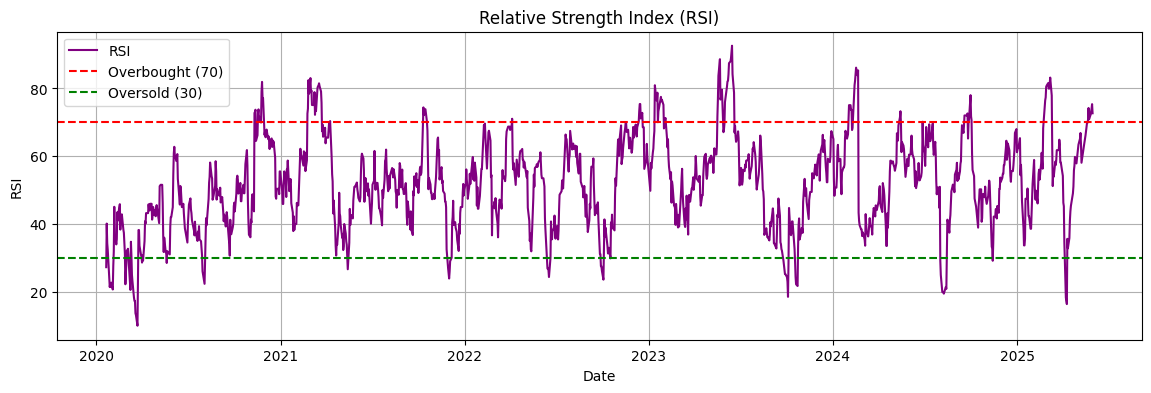

In [54]:
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()


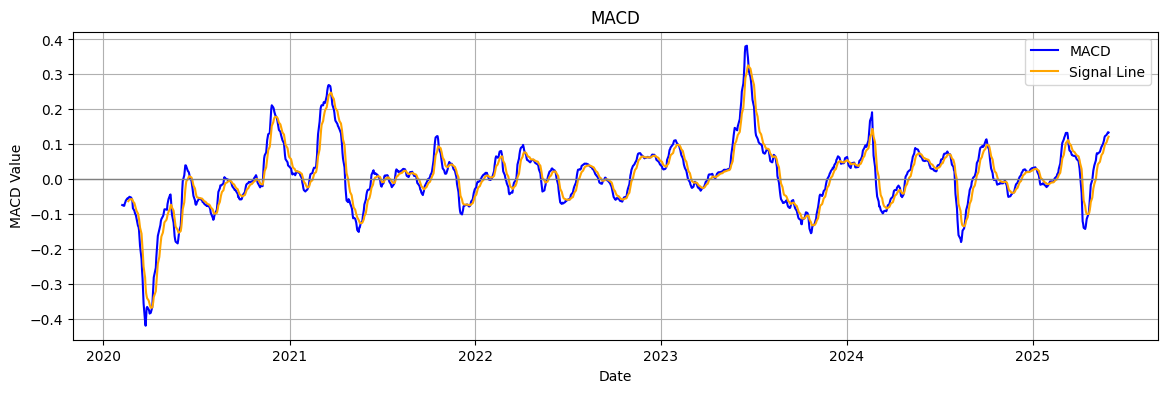

In [55]:
plt.figure(figsize=(14, 4))
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linewidth=1)
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()


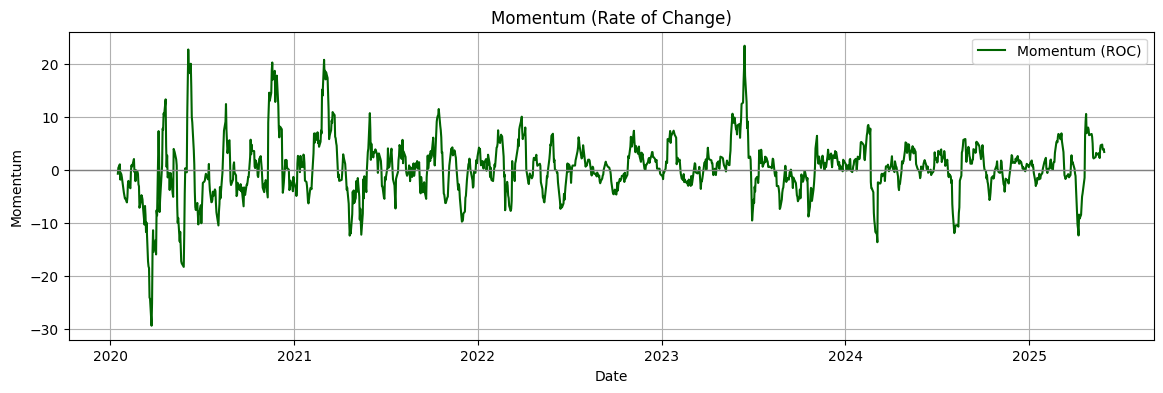

In [56]:
plt.figure(figsize=(14, 4))
plt.plot(df['Momentum'], label='Momentum (ROC)', color='darkgreen')
plt.axhline(0, color='gray', linewidth=1)
plt.title('Momentum (Rate of Change)')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)
plt.show()


In [29]:

from ta.trend import SMAIndicator

# Step 1: Download
df = yf.download('AAPL', start='2020-01-01', end='2025-06-01')
df.dropna(inplace=True)

# Step 2: Sanitize
close_series = pd.Series(df['Close'].values.squeeze(), index=df.index)

# Step 3: Apply SMA
sma = SMAIndicator(close=close_series, window=20)
df['SMA_20'] = sma.sma_indicator()

# Step 4: Verify
print(df[['Close', 'SMA_20']].tail())



/tmp/ipykernel_5882/3221385371.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2020-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

Price            Close      SMA_20
Ticker            AAPL            
Date                              
2025-05-23  195.270004  205.631774
2025-05-27  200.210007  205.149035
2025-05-28  200.419998  204.623365
2025-05-29  199.949997  204.009779
2025-05-30  200.850006  203.400248


In [25]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-06-1'

df = yf.download(ticker, start=start_date, end=end_date)
print(df.dtypes)
df.dropna(inplace=True)
df.head()

/tmp/ipykernel_5882/627908916.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200


In [27]:
from ta.trend import SMAIndicator
sma = SMAIndicator(close=df['Close'], window=20)
df['SMA_20'] = sma.sma_indicator()

ValueError: Data must be 1-dimensional, got ndarray of shape (1360, 1) instead

In [19]:

df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_50'] = ta.trend.ema_indicator(df['Close'], window=50)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd(df['Close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['Close'])
df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'], window=20, window_dev=2)
df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'], window=20, window_dev=2)       
df['Momentum'] = ta.momentum.roc(df['Close'], window=10)

ValueError: Data must be 1-dimensional, got ndarray of shape (1360, 1) instead